In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
rcParams['font.size'] = 20

# Part 1: Artificial data for linear regression

In [2]:
x_train = np.random.rand(100).astype(np.float32)
noise = np.random.normal(scale=0.01, size=len(x_train))
y_train = x_train * 0.1 + 0.3 + noise

In [3]:
x_eval = np.random.rand(len(x_train)).astype(np.float32)
noise = np.random.normal(scale=0.01, size=len(x_eval))
y_eval = x_eval * 0.1 + 0.3 + noise

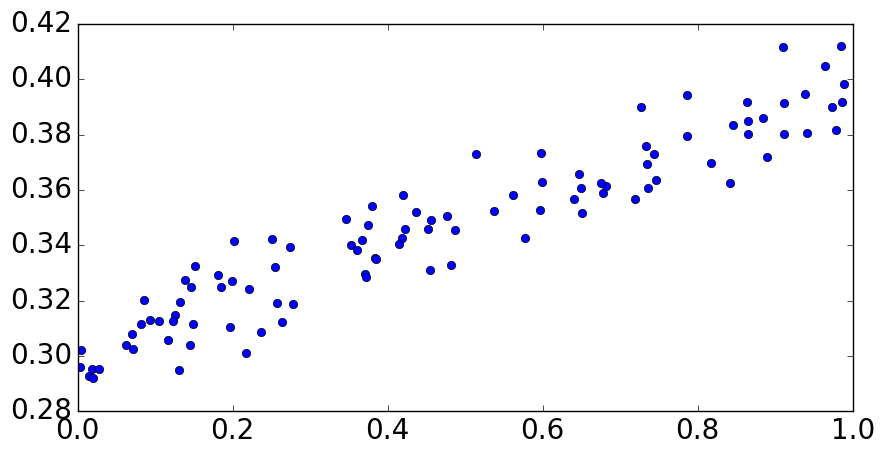

In [4]:
plt.plot(x_train, y_train, 'o')

In [5]:
def build_model(rate):
    W = tf.Variable(tf.random_normal([1]), name='weights')
    b = tf.Variable(tf.random_normal([1]), name='bias')
    x = tf.placeholder(shape=[None], dtype=tf.float32, name='x')
    y = W * x + b
    y_label = tf.placeholder(shape=[None], dtype=tf.float32, name='y_label')
    loss = tf.reduce_mean(tf.square(y - y_label))
    optimizer = tf.train.GradientDescentOptimizer(rate)
    train = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    return x, y, y_label, init, train, loss, W, b

In [6]:
rate_loss = []
rates = (0.01, 0.03, 0.1, 0.3, 0.5)
for rate in rates:
    x, y, y_label, init, train, loss, W, b = build_model(rate)
    lo = []
    with tf.Session() as sess:
        sess.run(init)
        for _ in range(100):
            sess.run(train, feed_dict={x: x_train, y_label: y_train})
            lo.append(sess.run(loss, feed_dict={x: x_eval, y_label: y_eval}))
        rate_loss.append(lo)

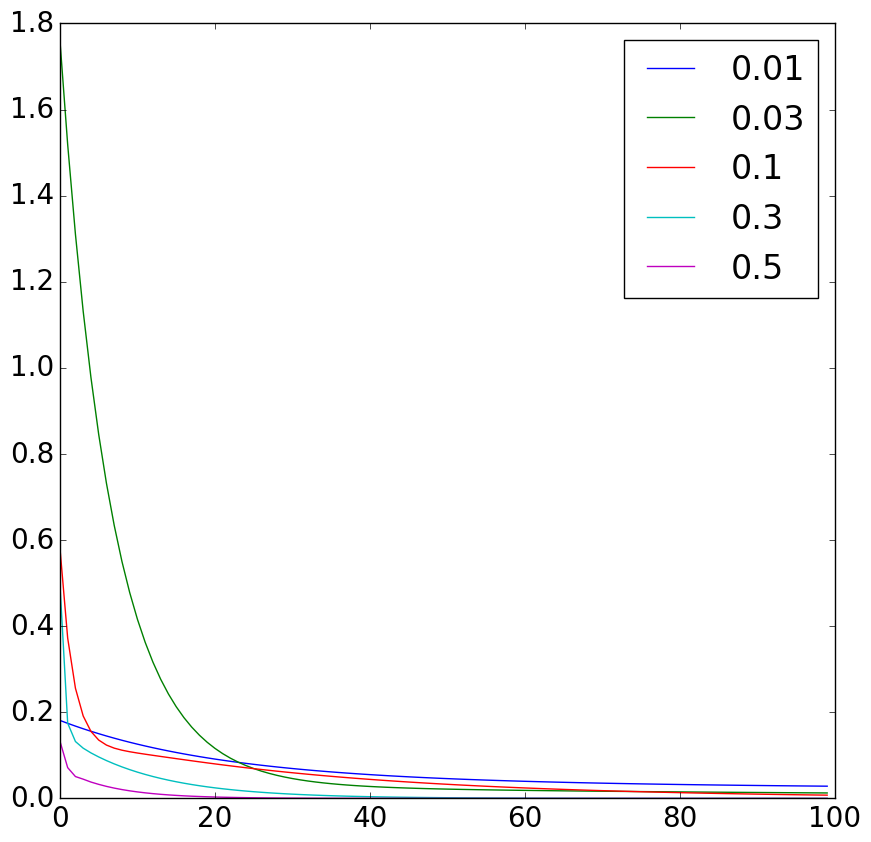

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
for l, r in zip(rate_loss, rates):
    ax.plot(l, label=r)
ax.legend()
plt.show()

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_grid(X1, X2, Y):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(azim=150)
    ax.set_xlabel('w')
    ax.set_ylabel('b')
    surf = ax.plot_surface(X1, X2, Y, color='w')
    plt.show()

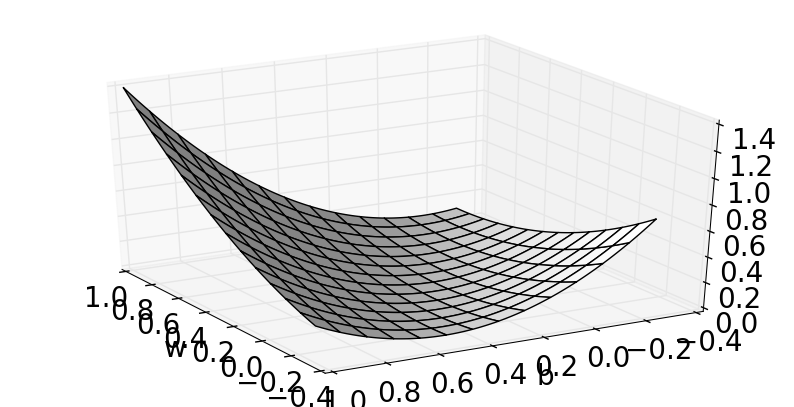

In [9]:
X1, X2 = np.mgrid[-0.3:1.0:0.01, -0.3:1.0:0.01]
Y = [(X1 * xs + X2 - ys) ** 2 for xs, ys in zip(x_eval, y_eval)]
Y = np.mean(np.array(Y), axis=0)
plot_3d_grid(X1, X2, Y)

# Part 2: Real data for logistic regression

In [25]:
house = pd.read_pickle('taipei_house.pickle')

feature = {}
feature[u'鄉鎮市區'] = sorted(list(set(house[u'鄉鎮市區'])))
feature[u'交易標的'] = sorted(list(set(house[u'交易標的'])))
feature[u'都市土地使用分區'] = sorted(list(set(house[u'都市土地使用分區'])))

In [26]:
def make_feature(df):
    d = sum([len(feature[k]) for k in feature]) + \
        len(df.columns) - len(feature) - 2
    x = np.zeros((len(df), d), dtype=float)
    y = np.array(df.iloc[:, -1], dtype=float)
    i = 0
    fname = []
    for name in df.columns[1:-1]:
        if name in feature:
            for item in feature[name]:
                fname.append(u'是否:' + item)
                x[:, i] = df[name] == item
                i += 1
        else:
            fname.append(name)
            x[:, i] = df[name]
            i += 1
    return x, y, fname

In [27]:
house_x, house_y, feature_name = make_feature(house)
val_sel = np.zeros(len(house_x), dtype=bool)
i = np.random.choice(np.arange(len(house_x)), len(house_x) // 10, replace=False)
val_sel[i] = True
x_train = house_x[~val_sel]
y_train = house_y[~val_sel]
x_eval = house_x[val_sel]
y_eval = house_y[val_sel]

In [28]:
def house_model(learn, decay):
    global_step = tf.Variable(0, trainable=False)
    rate = tf.train.exponential_decay(learn, global_step, 10000, decay)
    W = tf.Variable(tf.random_normal([1, 26], stddev=10000))
    b = tf.Variable(0, dtype=tf.float32)
    x = tf.placeholder(shape=[None, 26], dtype=tf.float32)
    y = tf.matmul(W, tf.transpose(x)) + b
    y_label = tf.placeholder(shape=[None], dtype=tf.float32)
    loss = tf.reduce_mean(tf.square(y - y_label))
    optimizer = tf.train.RMSPropOptimizer(rate)
    train = optimizer.minimize(loss, global_step=global_step)
    init = tf.global_variables_initializer()
    return x, y, y_label, init, train, loss, W, b

In [29]:
rate_loss = []
rates = (1000,)
x, y, y_label, init, train, loss, W, b = house_model(1000.0, 0.2)
lo = []
with tf.Session() as sess:
    sess.run(init)
    lo.append(sess.run(loss, feed_dict={x: x_eval, y_label: y_eval}))
    for j in range(1, 20000):
        sess.run(train, feed_dict={x: x_train, y_label: y_train})
        if j % 100 == 0:
            lo.append(sess.run(loss, feed_dict={x: x_eval, y_label: y_eval}))
            if lo[-1] > lo[-2]:
                break
            Wmin, bmin = sess.run([W, b])
        if j % 1000 == 0:
            print j, lo[-1]
    rate_loss.append(lo)

1000 3.00271e+10


In [30]:
print bmin

204574.0


In [24]:
for c, n in zip(Wmin[0], feature_name):
    print n, c

是否:中山區 173291.0
是否:中正區 108237.0
是否:信義區 214186.0
是否:內湖區 28203.4
是否:北投區 40387.3
是否:南港區 63576.1
是否:士林區 29077.8
是否:大同區 -97013.4
是否:大安區 427554.0
是否:文山區 -100151.0
是否:松山區 217888.0
是否:萬華區 -6072.69
是否:房地(土地+建物) 179267.0
是否:房地(土地+建物)+車位 166806.0
土地移轉總面積平方公尺 7554.93
是否:住 178898.0
是否:其他 128428.0
是否:商 238763.0
是否:工 -91455.1
交易年月日 11108.5
移轉層次 -14141.1
總樓層數 16900.1
建築完成年月 -2971.06
建物移轉總面積平方公尺 325.058
建物現況格局-房 -10749.4
建物現況格局-廳 -78874.4


In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
print lr.intercept_
for c, n in zip(lr.coef_, feature_name):
    print n, c

647069.83667
是否:中山區 84354.5444859
是否:中正區 30795.0935182
是否:信義區 129093.482612
是否:內湖區 -65305.693659
是否:北投區 -48716.7046538
是否:南港區 -25450.0870353
是否:士林區 -80055.8643203
是否:大同區 -196013.693699
是否:大安區 341863.93943
是否:文山區 -214694.078857
是否:松山區 152425.978352
是否:萬華區 -108296.916172
是否:房地(土地+建物) 1938.03620909
是否:房地(土地+建物)+車位 -1938.03620909
土地移轉總面積平方公尺 4708.75638276
是否:住 74168.6676116
是否:其他 38548.2076934
是否:商 131757.950659
是否:工 -244474.825964
交易年月日 5578.143147
移轉層次 -13333.5541919
總樓層數 12381.2817566
建築完成年月 -4019.97722386
建物移轉總面積平方公尺 335.905407079
建物現況格局-房 -9209.35625975
建物現況格局-廳 -81880.4499714
